# Actividad 4: Regresión logística

In [35]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

from tqdm import trange # tqdm nos permite medir el tiempo por iteración.
import warnings # ignoramos algunas warnings molestas.
warnings.filterwarnings('ignore')

En esta actividad trabajaremos con el dataset de [Credit Card Fraud](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud). A continuación separamos el dataset en muestras de entrenamiento y prueba:

In [36]:
df = pd.read_csv("card_transdata.csv")
y = df['fraud'].to_numpy()
df.drop(columns=['fraud'], inplace=True)
X = df.to_numpy()

N = 50000 # No cambiar esto!
# Sampleamos N datos estratificando por y
X, y = resample(X, y, n_samples=N, stratify=y)
print("X:", X.shape, "y:",y.shape)
print("Ratio of fraud: ", round(np.count_nonzero(y == 0) / np.count_nonzero(y == 1)), ": 1\n")

# Separamos el dataset en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
print("X_train:", X_train.shape, "y_train:",y_train.shape)
print("Ratio of fraud in train: ", round(np.count_nonzero(y_train == 0) / np.count_nonzero(y_train == 1)), ": 1\n")

print("X_test:", X_test.shape, "y_test:",y_test.shape)
print("Ratio of fraud in test: ", round(np.count_nonzero(y_test == 0) / np.count_nonzero(y_test == 1)), ": 1\n")

X: (50000, 7) y: (50000,)
Ratio of fraud:  10 : 1

X_train: (33500, 7) y_train: (33500,)
Ratio of fraud in train:  10 : 1

X_test: (16500, 7) y_test: (16500,)
Ratio of fraud in test:  10 : 1



## Mejorando una regresión logística con numpy.

**Recordatorio**: De forma general, a partir de una matriz de características $X$ (con una columna de 1's para el intersecto) y un vector de coeficientes o pesos $\beta$ (el cual incluye el intersecto) podemos definir unar regresión logística multiple como:

$$P = \frac{1}{1 + e^{-\beta X}}$$

Consideremos una regresión logística que emplea descenso de gradiente para ajustar sus coeficientes. El gradiente de la función objetivo para cada $\beta_i$ es:
$$ \frac{\delta}{\delta \beta_i}L(\beta) = \frac{lr}{m} \sum_{1 \leq j \leq m} (\sigma(\beta^T x^j) - y_j) x_i^j $$

Donde:
- $L(\beta)$ es la función de verosimilitud
- $lr$ es el learning rate -
- $\beta$ es el vector de coeficientes para la regresión
- tenemos $m$ filas en nuestro _dataset_
- $\sigma(x)$ es la función $\frac{1}{1 + e^{-x}}$
- $x^j$ es la fila $j$ de nuestro dataset (y asociado tiene su respuesta $y_j$)
- $x_i^j$ es la columna $i$ de la fila $j$ en nuestro _dataset_.

A continuación les entregamos una implementación de la regresión logística. Sin embargo, el método fit es algo ineficiente y no aprovecha todas las herramientas que ofrece numpy. Tu tarea es completar el método *fast_fit* **sin agregar más loops** y comprobar que de esta forma es más rápido que el *fit* original. Para esto basta que compares las iteraciones por segundo que registra trange().

**Hint**: Es posible prescindir del indice $j$ en el descenso de gradiente multiplicando vectorialmente. Para esto pueden utilizar [np.dot](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) o el operador @. No se necesitan más de 1 o 2 líneas de código. Revisa bien que se está haciendo en la sumatoria del descenso de gradiente.

In [23]:
def sigmoid(x):    
    output = 1 / (1 + np.exp(-x))
    return output

class LogisticRegression:
    def __init__(self, number_of_features, learning_rate=0.001, number_of_iterations=100):
        self.learning_rate = learning_rate
        self.number_of_iterations = number_of_iterations
        self.beta = np.zeros(number_of_features + 1) # Consideramos tambien el intercepto.
        
    def fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X] # Se concatena una columna de 1's para multiplicar el intercepto. 
        for _ in trange(self.number_of_iterations):
            for i in range(X.shape[1]):
                for j in range(X.shape[0]):
                    self.beta[i] = self.beta[i] - self.learning_rate/(X.shape[0]) * (sigmoid(self.beta @ X[j]) - y[j]) * X[j][i]
    
    def fast_fit(self, X, y):
        X = np.c_[np.ones(X.shape[0]), X]
        for _ in trange(self.number_of_iterations):
            for i in range(X.shape[1]):
                # COMPLETAR AQUÍ SIN AGREGAR MÁS LOOPS
                
                self.beta[i] = self.beta[i] - self.learning_rate/(X.shape[0]) * (sigmoid(self.beta @ X[j]) - y[j]) * X[j][i]
                pass

    def predict(self, x):
        x = np.c_[np.ones(x.shape[0]), x] # Se concatena una columna de 1's para multiplicar el intercepto. 
        pred = (sigmoid(self.beta @ x.T) > 0.5) * 1 # Consideramos que la clase es 1 si P > 0.5
        return pred

In [75]:
a = [[4, 7],
     [8, 3]]
b = [[4, 1],
     [2, 2]]
np.dot(a, b)

array([[30, 18],
       [38, 14]])

Como pueden ver, para ~50000 datos de entrenamiento el método *fit* toma más de 2 minutos (1.4 it/s).

In [24]:
reglog = LogisticRegression(X.shape[1], learning_rate=0.001, number_of_iterations=100)
reglog.fit(X_train, y_train)
y_pred = reglog.predict(X_test)
accuracy_score(y_test, y_pred)

100%|██████████| 100/100 [04:05<00:00,  2.46s/it]


0.9126060606060606

In [73]:

X_train.shape[0]
# li = []
# for i in range(X_train.shape[1]):
#     # print(X_train[i])
#     var = X_train[i]
#     li.append(var)
#     # print(pd.DataFrame(var))
# # print(X_train.ndim)
# # pd.DataFrame(li[1])
# pd.DataFrame(X_train)
# X = np.c_[np.ones(X_train.shape[0]), X_train]
# print(X)

33500

In [ ]:
reglog.fast_fit(X_train, y_train)
y_pred = reglog.predict(X_test)
accuracy_score(y_test, y_pred)

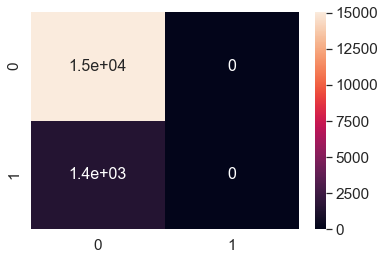

In [26]:
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

Muestra ahora como *fast_fit* es más rápido y obtiene una *accuracy* similar.

In [ ]:
# Responde aquí

## Analisis de predicciones.

Para esta sección puedes utilizar LogisticRegression de sklearn.linear_model.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

Entrena un modelo de regresión logística con los sets de train y utiliza el accuracy_score para tener una idea de que tan bien predice tu modelo (recuerda predecir para los sets de test). Luego, genera la matriz de confusión y **comenta** que dice cada dato en ella. **Explica** en tus palabras a que se debe la diferencia entre los valores en cada casilla.

In [28]:
# Entrena la regresión y calcula el accuracy
reglog = LogisticRegression(max_iter=100)
reglog.fit(X_train, y_train)
y_pred = reglog.predict(X_test)
accuracy_score(y_test, y_pred)

0.9553333333333334

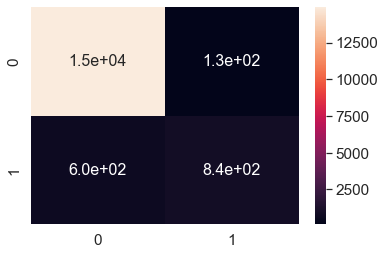

In [34]:
# Obtén la matriz de confusión
array = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

La matriz de confusión presenta 4 sectores, un verdadero positivo, un falso positivo, un falso negativo y un verdadero negativo. Cada uno de estos cuadrandtes representa lo que pasa con un valor clasificado. Los verdaderos positivos muestran aquellos datos que fueron clasificados correctamente en su categoria, los falsos positivos fueron los que fueron clasificados equivocadamente en una clase en particular. Las verdaderos negativos muestran los datos que no fueron clasificados en una clase de manera correcta, y los falsos negativos presentan aquellos dato que no fueron clasificados en una clase pero debería hacer sido clasificados.

Se puede ver como la mayoría de los datos son verdaderos positivos, lo que indica un correcto funcionamiento del algoritmo de clasificación.

Una vez hecha la matriz de confusion, utiliza sus datos para obtener la sensibilidad y la especificidad  del modelo. Muestra estos datos y **explica** que significan aplicados al tema.

**Hint**: averigua sobre verdadero positivo, negativo y falsos negativos y positivos

In [79]:
# Calcula la sensibilidad y especifidad
tn, fp, fn, tp = array.ravel()
(tn, fp, fn, tp)
specificity = tn / (tn+fp)
sensibility = tp / (tp+fn)
(specificity, sensibility)

(0.9912338956036658, 0.5804438280166435)

Finalmente, la regresión logística nos permite obtener la probabilidad de que un dato pertenezca a una clase. Las instancias de LogisticRegression de sklearn nos entregan estas probabilidades mediante el método [predict_proba](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_proba). Investiga como utilizarlo y haz un gŕafico que, para cada dato en test, permita visualizar la probabilidad de que un dato pertenezca a una clase vs su clase verdadera.

**Hint**: queda a tu criterio como hacer este gráfico mientras que se aprecie lo pedido. Sin embargo, se recomienda un histograma por clase donde se agrupa por probabilidades en cada columna (pueden usar el color para mostrar la clase verdadera).

In [32]:
# Haz tu gráfico aquí
y_pred_proba = reglog.predict_proba(X_test)
df_proba = pd.DataFrame(y_pred_proba)
df_proba


,0,1
0,0.999793,0.000207
1,0.999937,0.000063
2,0.918993,0.081007
3,0.972469,0.027531
4,0.999803,0.000197
...,...,...
16495,0.982573,0.017427
16496,0.975416,0.024584
16497,0.999837,0.000163
16498,0.963092,0.036908
